# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [22]:
import sys
sys.path.append('..')

from random import choice
from itertools import permutations

import pandas as pd
import networkx as nx

import socnet as sn

Configurando a biblioteca:

In [23]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [24]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

In [25]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [26]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [27]:
def simulate_single_flow(g, s, t, whichSuccessorGo, shouldKeep):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
        
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0
    
    funcs = [random_geodesic_successor,random_path_successor,random_trail_successor, random_walk_successor ]

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Deixa de ser dono do insumo.
            if(not shouldKeep):
                g.nodes[n]['owner'] = False

            # Escolhe aleatoriamente um dos sucessores.
            try:
                m = funcs[whichSuccessorGo-1](g, n)
            except:
                continue
                

            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [28]:
def simulate_successful_flow(g, s, t, whichSuccessorGo, shouldKeep):
    set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, whichSuccessorGo, shouldKeep)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [29]:
def simulate_all_flows(g,whichSuccessorGo, shouldKeep):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, whichSuccessorGo, shouldKeep)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [30]:
cc = nx.closeness_centrality(g)

bc = nx.betweenness_centrality(g)

E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

In [31]:
def simulate(g,whichFunc, shouldKeep):
    TIMES = 100


    for n in g.nodes:
        g.nodes[n]['mean_closeness'] = 0
        g.nodes[n]['mean_betweenness'] = 0

    for _ in range(TIMES):
        simulate_all_flows(g, whichFunc, shouldKeep)

        for n in g.nodes:
            g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
            g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

    for n in g.nodes:
        g.nodes[n]['mean_closeness'] /= TIMES
        g.nodes[n]['mean_betweenness'] /= TIMES

    return pd.DataFrame({
        'família': [g.nodes[n]['label'] for n in g.nodes],
        'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
        'closeness analítico': [cc[n] for n in g.nodes],
        'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
        'betweenness analítico': [bc[n] for n in g.nodes],
    })
    

In [32]:
a = simulate(g,1, True)
a

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.000000,0.333333,0.333333,ginori
1,0.000000,0.000000,0.325581,0.325581,lambertes
2,0.212454,0.569505,0.482759,0.482759,albizzi
3,0.260073,0.688022,0.466667,0.466667,guadagni
4,0.000000,0.000000,0.285714,0.285714,pazzi
5,0.142857,0.406593,0.388889,0.388889,salviati
6,0.521978,1.386703,0.560000,0.560000,medici
7,0.091575,0.244945,0.482759,0.482759,tornabuon
8,0.120879,0.313571,0.400000,0.400000,bischeri
9,0.086081,0.250000,0.482759,0.482759,ridolfi


In [33]:
b = simulate(g,1, False)
b

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.000000,0.333333,0.333333,ginori
1,0.000000,0.000000,0.325581,0.325581,lambertes
2,0.212454,0.208516,0.482759,0.482759,albizzi
3,0.260073,0.256374,0.466667,0.466667,guadagni
4,0.000000,0.000000,0.285714,0.285714,pazzi
5,0.142857,0.142857,0.388889,0.388889,salviati
6,0.521978,0.522967,0.560000,0.560000,medici
7,0.091575,0.092527,0.482759,0.482759,tornabuon
8,0.120879,0.119451,0.400000,0.400000,bischeri
9,0.086081,0.089560,0.482759,0.482759,ridolfi


In [34]:
c = simulate(g,2, True)
c

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.390000,0.333333,0.230763,ginori
1,0.000000,0.397418,0.325581,0.233836,lambertes
2,0.212454,0.617637,0.482759,0.259105,albizzi
3,0.260073,0.742418,0.466667,0.260873,guadagni
4,0.000000,0.261923,0.285714,0.204715,pazzi
5,0.142857,0.439670,0.388889,0.225162,salviati
6,0.521978,0.821868,0.560000,0.267582,medici
7,0.091575,0.679835,0.482759,0.282762,tornabuon
8,0.120879,0.647637,0.400000,0.262723,bischeri
9,0.086081,0.699451,0.482759,0.272016,ridolfi


In [35]:
d = simulate(g,2, False)
d

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.000000,0.333333,0.204687,ginori
1,0.000000,0.000000,0.325581,0.209314,lambertes
2,0.212454,0.230000,0.482759,0.255920,albizzi
3,0.260073,0.405549,0.466667,0.266699,guadagni
4,0.000000,0.000000,0.285714,0.200712,pazzi
5,0.142857,0.142857,0.388889,0.251685,salviati
6,0.521978,0.632033,0.560000,0.305696,medici
7,0.091575,0.329780,0.482759,0.253883,tornabuon
8,0.120879,0.367253,0.400000,0.245701,bischeri
9,0.086081,0.367967,0.482759,0.253552,ridolfi


In [36]:
e = simulate(g,3, True)
e

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.377637,0.333333,0.224061,ginori
1,0.000000,0.397637,0.325581,0.226254,lambertes
2,0.212454,0.688022,0.482759,0.247081,albizzi
3,0.260073,0.899670,0.466667,0.254471,guadagni
4,0.000000,0.267253,0.285714,0.199613,pazzi
5,0.142857,0.426813,0.388889,0.219851,salviati
6,0.521978,1.259066,0.560000,0.250680,medici
7,0.091575,0.929286,0.482759,0.262473,tornabuon
8,0.120879,0.783681,0.400000,0.249548,bischeri
9,0.086081,0.928846,0.482759,0.262604,ridolfi


In [37]:
f = simulate(g,3, False)
f

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.000000,0.333333,0.218198,ginori
1,0.000000,0.000000,0.325581,0.205459,lambertes
2,0.212454,0.262527,0.482759,0.262128,albizzi
3,0.260073,0.410220,0.466667,0.264593,guadagni
4,0.000000,0.000000,0.285714,0.196353,pazzi
5,0.142857,0.142857,0.388889,0.237513,salviati
6,0.521978,0.703736,0.560000,0.284753,medici
7,0.091575,0.323571,0.482759,0.251140,tornabuon
8,0.120879,0.348352,0.400000,0.231147,bischeri
9,0.086081,0.336978,0.482759,0.246739,ridolfi


In [38]:
h = simulate(g,4, True)
h

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.807473,0.333333,0.140714,ginori
1,0.000000,0.712857,0.325581,0.145069,lambertes
2,0.212454,3.085549,0.482759,0.163156,albizzi
3,0.260073,4.543516,0.466667,0.161224,guadagni
4,0.000000,0.757582,0.285714,0.127315,pazzi
5,0.142857,1.803462,0.388889,0.142077,salviati
6,0.521978,6.951099,0.560000,0.168734,medici
7,0.091575,2.430330,0.482759,0.167735,tornabuon
8,0.120879,2.766978,0.400000,0.155854,bischeri
9,0.086081,2.558352,0.482759,0.166798,ridolfi


In [39]:
i = simulate(g,4, False)
i

,betweenness analítico,betweenness simulado,closeness analítico,closeness simulado,família
0,0.000000,0.760989,0.333333,0.037777,ginori
1,0.000000,0.765055,0.325581,0.037219,lambertes
2,0.212454,2.489451,0.482759,0.035420,albizzi
3,0.260073,3.367527,0.466667,0.036260,guadagni
4,0.000000,0.699505,0.285714,0.042858,pazzi
5,0.142857,1.534780,0.388889,0.036924,salviati
6,0.521978,5.040275,0.560000,0.036690,medici
7,0.091575,2.482198,0.482759,0.032688,tornabuon
8,0.120879,2.455385,0.400000,0.034559,bischeri
9,0.086081,2.496319,0.482759,0.034664,ridolfi


## Analisando o dataframe A (Geodésicas)

In [51]:
import numpy as np
import matplotlib.pyplot as plt

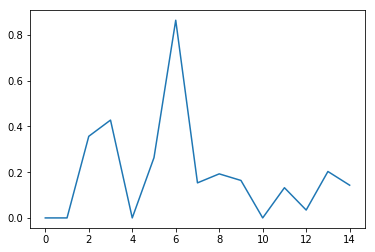

In [52]:
result = np.abs(a["betweenness analítico"] - a["betweenness simulado"])
plt.plot(result)
plt.show()

em média o erro entre o simulado e o analítico foi de

In [54]:
print(result.mean())

0.1957435897435898


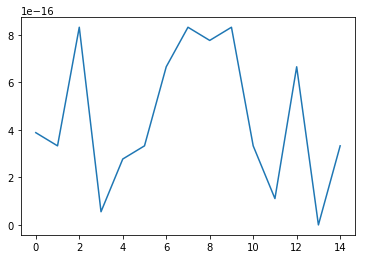

In [53]:
result_two = np.abs(a["closeness analítico"] - a["closeness simulado"])
plt.plot(result_two)
plt.show()

em média o erro entre o simulado e o analítico foi de

In [55]:
print(result_two.mean())

4.51490696680897e-16


Por enquanto analisando esses resultados percebe-se que manter o pacote influenciou mais na disparidade dos resultados em relação ao betweness do que ao closeness. Vamos analisar agora se a sequência de "importância" mantêm-se.

In [ ]:
sequence_analitico = []
for i in range(0,len(a["closeness analítico"])):
    data  ={}
    sequence_analitico.append()